## Imports Part

In [ ]:
import pandas as pd 
import numpy as np
import random
from google.colab import files
import io
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import chi2_contingency

## Read Data

In [ ]:
uploaded = files.upload()

Saving dataset.csv to dataset (1).csv


In [ ]:
df = pd.read_csv(io.BytesIO(uploaded['dataset.csv']))

## Data Exploration and Preprocessing

First we use describe() method to get some basic statistical summary of the data frame. As we see the minimum Rate is -3, by further exploration we could see there are some rows which we need to delete due to allowed range for Rate column.

In [ ]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,24855,24855,QsEFjiCUFKGRXXCQFNDX2U,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ProId,24855,4161,qv8L6yefk2guJzZn4FtGMj,700,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ProCreationTimestamp,24855,NaN,NaN,NaN,1.54304e+12,1.63998e+10,1.50773e+12,1.53228e+12,1.54495e+12,1.55594e+12,1.57583e+12
CustId,24855,19284,muDxBgbnj7oWew7k6stcLw,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CustCreationTimestamp,24855,NaN,NaN,NaN,1.55151e+12,1.61106e+10,1.49735e+12,1.54211e+12,1.55499e+12,1.56355e+12,1.57591e+12
Rate,24855,NaN,NaN,NaN,4.30006,1.29598,-3,4,5,5,5
TaskCreationTimestamp,24855,NaN,NaN,NaN,1.55613e+12,1.51506e+10,1.49735e+12,1.5484e+12,1.55975e+12,1.56725e+12,1.57596e+12
Price,18866,NaN,NaN,NaN,513764,4.70742e+06,0,65000,110000,282000,3.6e+08
ServiceId,24855,213,UX7m6RWnKWvmw82URCyUMB,4203,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CategoryId,24855,8,VzkJEPR5H3mnqctJ8TW3YS,22629,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df = df[(df.Rate>=0) & (df.Rate<=5)]
df.shape

(24851, 14)

By checking the frequency of the target variable that is fraudulent and not fraudulent we understand that we are faced with an imbalanced dataset

In [ ]:
df.isFraud.value_counts()

False    23311
True      1540
Name: isFraud, dtype: int64

Visualize the target variable

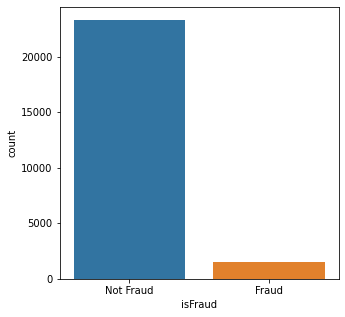

In [ ]:
plt.figure(figsize=(5,5))
ax = sns.countplot(data=df, x="isFraud")
ax.set_xticklabels(['Not Fraud','Fraud'])
plt.show()

</br>
</br>

In [ ]:
df.TaskState.value_counts()

Finished    24849
Waiting         1
Canceled        1
Name: TaskState, dtype: int64

Check for missing values

In [ ]:
df.isna().sum()

id                           0
ProId                        0
ProCreationTimestamp         0
CustId                       0
CustCreationTimestamp        0
Rate                         0
TaskCreationTimestamp        0
Price                     5987
ServiceId                    0
CategoryId                   0
ZoneId                       0
TaskState                    0
TargetProId              22300
isFraud                      0
dtype: int64

Fill missing value of price with the mean of price column

In [ ]:
df["hasPrice"] = df.Price.notna()
df.Price.fillna(df.Price.mean(), inplace=True)

 Make a column to see if the customer prefer a specific professional

In [ ]:
df["hasTargetPro"] = df.TargetProId.notna()

Make two column to measure time delta between the creation of professional account and customer account and time delta between customer account creation and task creation time

In [ ]:
df["DeltaProCustCreationTimestamp"] = abs(df.ProCreationTimestamp - df.CustCreationTimestamp)
df["DeltaCustTaskCreationTimestamp"] = abs(df.CustCreationTimestamp - df.TaskCreationTimestamp)

Check to see if there is a relationship between fraudulent and filling the TargetProId (as the p_value is less then 0.05 so we reject the null hypothesis and we can say there is a relationship between being fraudulent and having the TargetProId)

In [ ]:
table = pd.crosstab(df.isFraud, df.hasTargetPro)
chi2, pval, dof, expected = chi2_contingency(table)
pval

0.0003302236575024572

Check to see if there is a relationship between fraudulent and the Price column having a value (as the p_value is less then 0.05 so we reject the null hypothesis and we can say there is a relationship between being fraudulent and  the Price column being filled)

In [ ]:
table = pd.crosstab( df.isFraud, df.hasPrice)
chi2, pval, dof, expected = chi2_contingency(table)
pval

0.00031995134144622466

## Convert Categorical data to numerical

In [ ]:
df["isFraud"] = df.isFraud.map({False:0, True:1})
df["hasTargetPro"] = df.hasTargetPro.map({False:0, True:1})
df["hasPrice"] = df.hasPrice.map({False:0, True:1})
df = pd.get_dummies(data=df, columns=['CategoryId'], drop_first=True)

</br>

In [ ]:
df.columns

Index(['id', 'ProId', 'ProCreationTimestamp', 'CustId',
       'CustCreationTimestamp', 'Rate', 'TaskCreationTimestamp', 'Price',
       'ServiceId', 'ZoneId', 'TaskState', 'TargetProId', 'isFraud',
       'hasPrice', 'hasTargetPro', 'DeltaProCustCreationTimestamp',
       'DeltaCustTaskCreationTimestamp', 'CategoryId_HnKFgSQGdwEj7q6Z8ws4cb',
       'CategoryId_JdqYJwUosvwivsFdThmcXe',
       'CategoryId_L3a2wDTjmBCiSEE5nzkomU',
       'CategoryId_VzkJEPR5H3mnqctJ8TW3YS',
       'CategoryId_kRyJUveqktavaCXyhPdceK',
       'CategoryId_qgqzVtnssiJTjR7tjbWW6m',
       'CategoryId_v97njuq76L7f36VHZPbuJX'],
      dtype='object')

In [ ]:
X = df.drop(columns=["isFraud", "id", "ProId", "CustId", "ServiceId", "TargetProId", "TaskState", "ZoneId" ])
y = df.isFraud

## Split Data to Train and Test parts

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1) 

In [ ]:
train = pd.concat([X_train, y_train], axis = 1)


## Up Sampling

Since our data is imbalanced we need to balance it. The approach that we used here is up sampling because we don't have a lot of data.

In [ ]:
# separate the samples of two classes(Fraudulent and normal cases) into distinct data frames
Fraud_df = train[train.isFraud == 1]
NO_Fraud_df = train[train.isFraud == 0]

# resample the minority class up to majority class size
up_sample_size = NO_Fraud_df.shape[0]
Up_Sample_Fraud_df = resample(Fraud_df, n_samples=up_sample_size , random_state=1, replace = True)
Up_Sample_Fraud_df.shape

# merge the two data frames to make a balanced data frame
udf = pd.concat([Up_Sample_Fraud_df, NO_Fraud_df], axis = 0)
# shuffle data
udf = udf.sample(frac=1)

## Normalization

In [ ]:
normalizer = MinMaxScaler()
X_train_normal_u = normalizer.fit_transform(udf.drop(columns="isFraud"))
X_test_normal_u = normalizer.transform(X_test)

## Random Forest

Because of hierarchical structure of trees they allow us to consider both classes and have a quite good performance among other classic machine learning algorithms with imbalanced data. Here we used random forest cause it's better than a tree because of less overfitting problem.

Accuracy is not a good metric for our imbalanced problem. A better metric can be f1 score and auc score. Also percision is more important than recall in our problem as in our problem false-positive is more of a concern.

In [ ]:
rf = RandomForestClassifier(n_estimators = 500, random_state = 1)
rf.fit(udf.drop(columns="isFraud"), udf.isFraud)
y_pred = rf.predict(X_test)

print("accuracy score: {:.2f}".format(accuracy_score(y_test, y_pred)))
print("f1_score: {:.2f}".format(f1_score(y_test, y_pred)))
print("recall score: {:.2f}".format(recall_score(y_test, y_pred)))
print("precision score: {:.2f}".format(precision_score(y_test, y_pred)))
print("roc_auc score: {:.2f}".format(roc_auc_score(y_test, y_pred)))

accuracy score: 0.95
f1_score: 0.54
recall score: 0.44
precision score: 0.69
roc_auc score: 0.71
